In [48]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
             include_top=False,
                  input_shape=(512, 512, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [37]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/sabrinaaliyeva/Desktop/Insight/data/CNN_data/Tanzania/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 16, 16, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(512, 512),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 448)
validation_features, validation_labels = extract_features(test_dir, 160)
#validation_features, validation_labels = train_features, train_labels
#test_features, test_labels = extract_features(test_dir, 63)


Found 448 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [38]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(16, 16, 512)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 448 samples, validate on 160 samples
Epoch 1/50
448/448 [==============================] - 8s - loss: 0.6673 - acc: 0.5915 - val_loss: 0.6710 - val_acc: 0.5375
Epoch 2/50
448/448 [==============================] - 6s - loss: 0.6487 - acc: 0.6272 - val_loss: 0.6646 - val_acc: 0.5375
Epoch 3/50
448/448 [==============================] - 6s - loss: 0.6260 - acc: 0.6674 - val_loss: 0.6452 - val_acc: 0.6562
Epoch 4/50
448/448 [==============================] - 7s - loss: 0.6015 - acc: 0.6920 - val_loss: 0.6564 - val_acc: 0.5625
Epoch 5/50
448/448 [==============================] - 7s - loss: 0.5830 - acc: 0.7143 - val_loss: 0.6111 - val_acc: 0.7188
Epoch 6/50
448/448 [==============================] - 7s - loss: 0.5615 - acc: 0.7388 - val_loss: 0.6210 - val_acc: 0.6625
Epoch 7/50
448/448 [==============================] - 7s - loss: 0.5487 - acc: 0.7478 - val_loss: 0.5900 - val_acc: 0.7125
Epoch 8/50
448/448 [==============================] - 7s - loss: 0.5092 - acc: 0.7768 - val_l

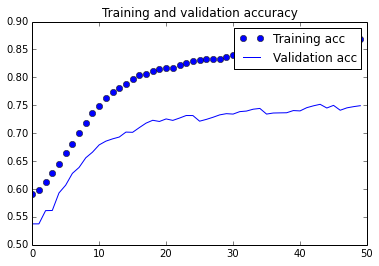

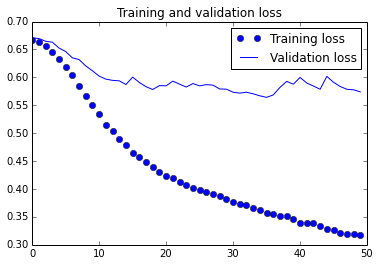

In [46]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.get_backend()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
from keras import models
from keras import layers

full_model=models.Sequential()
full_model.add(conv_base)
full_model.add(model)


full_model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [41]:
full_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 459137    
Total params: 15,173,825
Trainable params: 15,173,825
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Saving the model:
save_dir='/Users/sabrinaaliyeva/Desktop/Insight/data/CNN_data/Tanzania/'
full_model.save(save_dir+'two_class_poverty.h5')

In [45]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = full_model.evaluate_generator(test_generator, steps=50)
print('Test accuracy: %.4f%%' % test_acc)



Test accuracy: 0.7530%


In [79]:
from sklearn.datasets import load_files    
from keras.utils import np_utils

from keras.preprocessing import image                  
from tqdm import tqdm

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 2)
    return files, targets

valid_files, valid_targets = load_dataset('/Users/sabrinaaliyeva/Desktop/Insight/data/CNN_data/Tanzania/test')

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(512, 512))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = paths_to_tensor(valid_files).astype('float32')/255




100%|██████████| 160/160 [00:01<00:00, 85.99it/s]


In [ ]:

predictions = [np.argmax(full_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]



In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(valid_targets, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

'MacOSX'